### Pilotes

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

### Datos

In [2]:
# Datos:
Gamma = 2400 # Kg/m^3
E = 20000000000 # Modulo de elasticidad en Pa
Vp = math.sqrt(E/Gamma) # Velocidad de ondas de corte s^(-1)*m
print(f"Velocidad de ondas de corte: {round(Vp,2)} s^(-1)*m")
Vs = 500 # Velocidad de propagación de las ondas de corte en el terreno(m/s)
L = 6 # Longitud del pilote (m)
k = 40*10*(100**3) #Rigidez a la fricción del suelo(N/m^3)
c = 0.01*10*(100*3) #Coeficiente de amortiguamiento del suelo (N*sec/m^3)
phi = 0.40 # Diámetro del pilote(m)
K = (50*E*math.pi*(phi**2)*Vs)/(4*L*Vp) # Rigidez de la punta del pilote(N/m)
print(f"Rigidez de la punta del pilote: {K} N/m")
C = K*0.026*L/Vs # Coeficiente de amortiguamiento de la punta del pilote(N/(m*s^(-1)))
print(f"Coeficiente de amortiguamiento de la punta del pilote: {C} N/(m*s^(-1)")

Velocidad de ondas de corte: 2886.75 s^(-1)*m
Rigidez de la punta del pilote: 3627598728.468436 N/m
Coeficiente de amortiguamiento de la punta del pilote: 1131810.8032821517 N/(m*s^(-1)


## Función excitación

In [3]:
# Funcion de excitacion
    
intervalo = np.arange(0,1,0.00001)
intervalo = [round(j,5) for j in intervalo]

eventos = {}
res = 0
def p(t):
    global res
    if t<0.0001:
        res = 500000*t/0.0001
    elif 0.0001<t<=0.0006:
        res = 500000
    elif 0.0006<t<=0.0007:
        res = 500000*(1-((t-0.0006)/0.0001))
    elif t>0.0007:
        res = 0
    return res

for i in intervalo:
    eventos[i] = round(p(i),2) 

#h = [eventos.get(f"{i}") for i in range(0, len(eventos))]    


## Resolucion numerica por el metodo de las caracteristicas

In [4]:
n_L = 100 # numero de segnmentos del pilote
c_sigma = math.sqrt(E/Gamma) # velocidad de onda de tension en m/s
Delta_x = L/n_L # longitud del segmento
Delta_t = Delta_x/c_sigma
n_p = 3*(L/c_sigma)*(1/Delta_t)

# Funciones:

xi = [round(i*Delta_x, 5) for i in range(0,n_L+1)]
fii = [0.4 for i in range(0, n_L+1)]
ki = [k for i in range(0,n_L+1)]
ci = [c for i in range(0,n_L+1)]
ai = [math.sqrt(Gamma*E)*(fii[i]**2) for i in range(0,n_L+1)]
bi = [Gamma*(fii[i]**2) for i in range(0,n_L+1)]


fi_prima = [(fii[i+1]-fii[i])/(xi[i+1]-xi[i]) for i in range(0,n_L)]
fi_prima.insert(n_L+1,0)

u = 0
u_prima = 0
up = 0

e = [2*E*fii[i]*fi_prima[i]*u_prima-4*ci[i]*fii[i]*up-4*ki[i]*fii[i]*u for i in range(0,n_L+1)]   


## Matriz de coeficientes para calculo en el tramo del pilote

In [5]:
from numpy.linalg import det, inv

I = [0]

for i in range(1, n_L):
    a11 = ai[i-1]+ai[i]+2*E*fii[i]*fi_prima[i]*Delta_t
    a12 = -(bi[i-1]+bi[i])-4*ci[i]*fii[i]*Delta_t
    a13 = -4*ki[i]*fii[i]*Delta_t
    a21 = -(ai[i-1] + ai[i]) + 2*E*fii[i]*fi_prima[i]*Delta_t
    a22 = -(bi[i] + bi[i+1])-4*ci[i]*fii[i]*Delta_t
    a23 = a13
    a31 = 0
    a32 = -Delta_t/2
    a33 = 1
    
    matrix = inv([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
    
    I.append(matrix)

    

    
    

## Matriz de coeficientes para calculo en la punta del pilote

In [6]:
a210 = -(ai[0]+ai[1])
a220 = -(bi[0]+bi[1])

I0 = inv([[(1-(4*(ci[0]*fii[0]/a220)*Delta_t)), -(4*(ki[0]*fii[0]/a220)*Delta_t)],
          [-Delta_t/2, 1]])


## Matriz de coeficientes para calculo en la base del pilote

In [7]:
a11 = ai[n_L-1]+ai[n_L]+2*E*fii[n_L]*fi_prima[n_L]*Delta_t
a12 = -(bi[n_L-1]+bi[n_L])-4*ci[n_L]*fii[n_L]*Delta_t
a13 = -4*ki[n_L]*fii[n_L]*Delta_t
a21 = ((math.pi)/4)*((fii[n_L])**2)*E
a22 = C
a23 = K
a31 = -Delta_x/2
a32 = -Delta_t/2
a33 = 1
    
In = inv([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])



## Integracion numerica

In [21]:
def e(x, u, u_prima, up):
    e = (2*E*fii[x]*fi_prima[x]*u_prima)-(4*ci[x]*fii[x]*up)-(4*ki[x]*fii[x]*u) 
    return e

u = np.zeros((n_L+1, int(n_p)+1))
up = np.zeros((n_L+1, int(n_p)+1))
u_prima = np.zeros((n_L+1, int(n_p)+1))

for j in range(0, int(n_p)+1):
    
    c = j*Delta_t
    
    u_prima[0][j] = -4*(p((c)))/(math.pi*E*(fii[0]**2))
    
    for i in range(0, n_L+1):
        u[i][j] = 0
        up[i][j] = 0
        
        if i != 0:
            u_prima[i][j] = 0
    
for j in range(1, int(n_p)+1):
    for i in np.arange(int((1+((-1)**(j+1)))/2),
                    min(j,n_L+1),
                    2):

        if i != 0:
            eA = e((i-1), u[i-1][j-1], u_prima[i-1][j-1], up[i-1][j-1])
            
        if i != n_L:
            eB = e(i+1, u[i+1][j-1], u_prima[i+1][j-1], up[i+1][j-1])

        if i == 0:
            q4 = up[1][j-1]-(1/a220)*(a210*(u_prima[0][j]-u_prima[1][j-1])+eB*Delta_t)-((2*E*fii[0]*fi_prima[0]*u_prima[0][j]*Delta_t)/a220)
            q5 = u[1][j-1]-(Delta_x/2)*(u_prima[0][j]+u_prima[1][j-1])+(Delta_t/2)*up[1][j-1]
            up[0][j] = I0[0][0]*q4+I0[0][1]*q5
            u[0][j] = I0[1][0]*q4+I0[1][1]*q5

                   
        if i == n_L:
            q1 = (ai[i-1]+ai[i])*u_prima[i-1][j-1]-(bi[i-1]+bi[i])*up[i-1][j-1]-eA*Delta_t
            q2 = 0
            q3 = u[i-1][j-1]+(Delta_x/2)*u_prima[i-1][j-1]+(Delta_t/2)*up[i-1][j-1]
            u_prima[i][j] = In[0][0]*q1+In[0][1]*q2+In[0][2]*q3
            up[i][j] = In[1][0]*q1+In[1][1]*q2+In[1][2]*q3
            u[i][j] = In[2][0]*q1+In[2][1]*q2+In[2][2]*q3
            
        if i != 0 and i != n_L:
            q1 = (ai[i-1]+ai[i])*u_prima[i-1][j-1]-(bi[i-1]+bi[i])*up[i-1][j-1]-eA*Delta_t
            q2 = -(ai[i]+ai[i+1])*u_prima[i+1][j-1]-(bi[i]+bi[i+1])*up[i+1][j-1]-eB*Delta_t
            q3 = ((u[i-1][j-1]+u[i+1][j-1])/2)+(Delta_x/4)*(u_prima[i-1][j-1]-u_prima[i+1][j-1])+(Delta_t/4)*(up[i-1][j-1]+up[i+1][j-1])
            u_prima[i][j] = I[i][0][0]*q1+I[i][0][1]*q2+I[i][0][2]*q3
            up[i][j] = I[i][1][0]*q1+I[i][1][1]*q2+I[i][1][2]*q3
            u[i][j] = I[i][2][0]*q1+I[i][2][1]*q2+I[i][2][2]*q3
            

## Plot u´

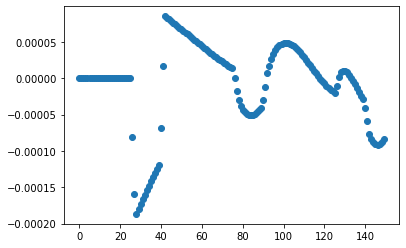

In [22]:
u2 = np.zeros((100,150))

for i in range(0, n_L):
    for j in range(0, int(n_p), 2):
        u2[i][int(j/2)] = u_prima[i][j]

import matplotlib.pyplot as plt

y = u2[50]
x = [i for i in range(0,150)]



plt.scatter(x, y)
plt.show()

## Plot u

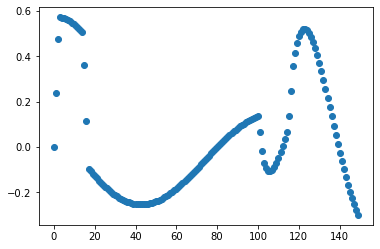

In [10]:
u3 = np.zeros((100,150))

for i in range(0, n_L):
    for j in range(0, int(n_p), 2):
        u3[i][int(j/2)] = up[i][j]

import matplotlib.pyplot as plt

y = u3[0]
x = [i for i in range(0,150)]



plt.scatter(x, y)
plt.show()